In [1]:
import cv2
import matplotlib.pyplot as plt
from os.path import isfile
import torch.nn.init as init
import torch
import torch.nn as nn
import numpy as np
import pandas as pd 
import os
from PIL import Image
#from keras.preprocessing.image import img_to_array, array_to_img
print(os.listdir("../input"))
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torchvision import transforms
from torch.optim import Adam, SGD
import time
from torch.autograd import Variable
import torch.functional as F
from tqdm import tqdm
from sklearn import metrics

['sample_submission.csv', 'train', 'test', 'train_labels.csv']


In [2]:
train = '../input/train/'
test = '../input/test/'
train_labels = pd.read_csv('../input/train_labels.csv')
cancer = train_labels[train_labels.label == 1].id.values
no_cancer = train_labels[train_labels.label == 0].id.values
print(len(cancer))
print(len(no_cancer))
lr = 0.01
n_epochs = 10

train_df, val_df = train_test_split(train_labels, test_size=0.2, random_state=2018)
train_df.to_csv('../working/train.csv', index=False)
val_df.to_csv('../working/val.csv', index=False)

89117
130908


In [3]:
def expand_path(p):
    if isfile(train + p + ".tif"):
        return train + p + ".tif"
    if isfile(test + p + ".tif"):
        return test + p + ".tif"
    return p

def p_show(imgs, label_name, per_row=3):
    n = len(imgs)
    rows = (n + per_row - 1)//per_row
    cols = min(per_row, n)
    fig, axes = plt.subplots(rows,cols, figsize=(15,15))
    for ax in axes.flatten(): ax.axis('off')
    for i,(img,ax) in enumerate(zip(imgs, axes.flatten())): 
       #img = array_to_img(img)
        ax.imshow(img) 
    fig.suptitle(label_name)

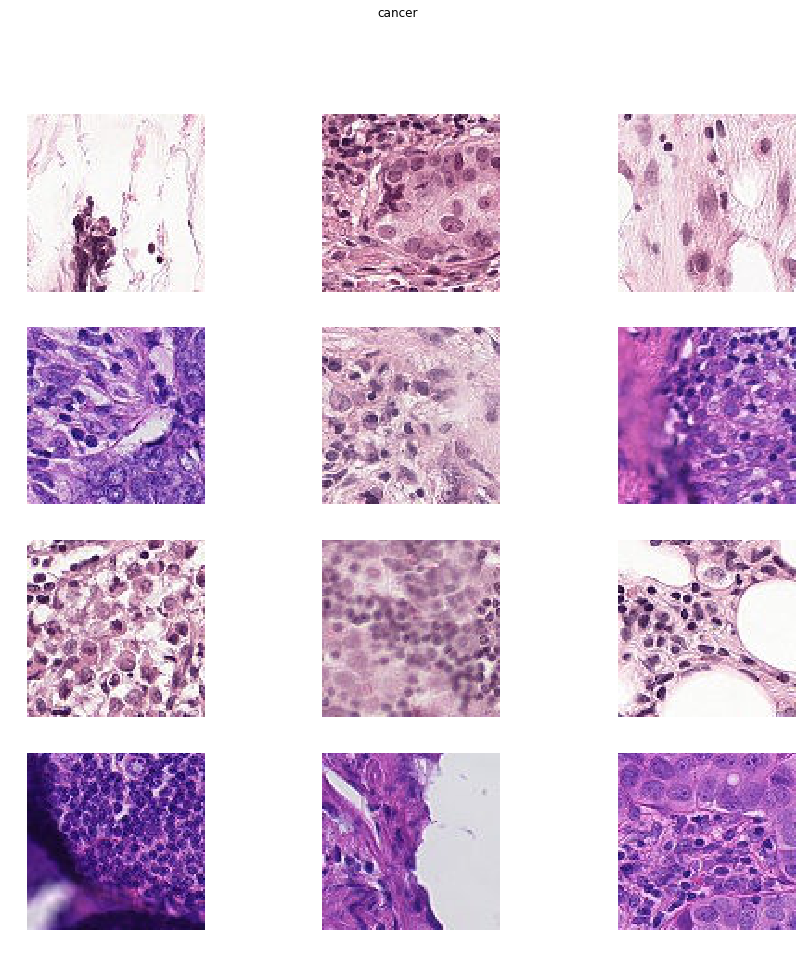

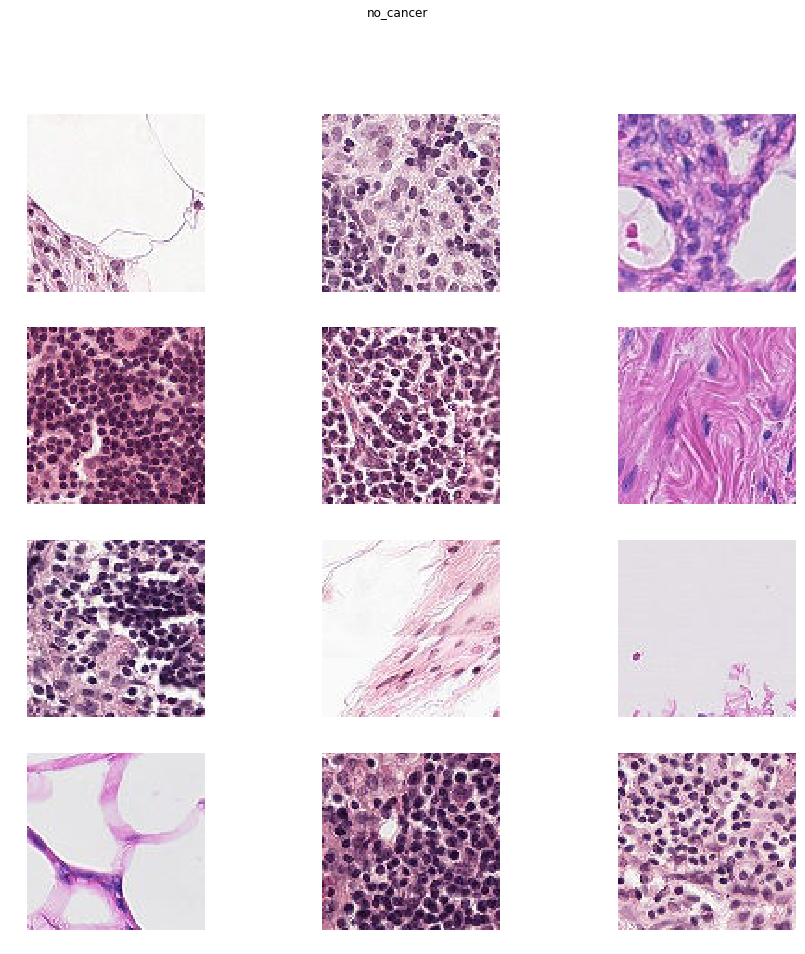

In [4]:
cancer_imgs = []
no_cancer_imgs = []
for p in cancer:
    img = Image.open(expand_path(p))
    cancer_imgs.append(img)
    if len(cancer_imgs) == 12: break
        
for p in no_cancer:
    img = Image.open(expand_path(p))
    no_cancer_imgs.append(img)
    if len(no_cancer_imgs) == 12: break
        
p_show(cancer_imgs, 'cancer')
p_show(no_cancer_imgs, 'no_cancer')

In [5]:
#torch.utils.data.Dataset
#All other datasets should subclass it. All subclasses should override __len__, that provides the size of the dataset, 
#and __getitem__, supporting integer indexing in range from 0 to len(self) exclusive.

class MyDataset(Dataset):
    
    def __init__(self, file_path, root_path, transform=None):
        self.csv = pd.read_csv(file_path)
        self.root_path = root_path
        self.transform = transform
        
    def __len__(self):
        return len(self.csv)
    
    def __getitem__(self, idx):
        
        label = self.csv.label.values[idx]
        label = np.expand_dims(label,-1)
        p = self.csv.id.values[idx]
        p_path = os.path.join(self.root_path, p +'.tif')
        #print(p_path)
        img = Image.open(p_path)
        #img = img_to_array(img)
        
        if self.transform:
            img = self.transform(img)
        
        return img, label

In [6]:
#ToTensorはnumpy形式のデータをpytorchでの計算に用いるtensor型へ変換する役割があります．
#自分定義したTransform, callメソッドの中にデータに加えたい処理を書きます．
#標準で用意されているTransformを用いる際はデータ形式をPIL Imageにする必要があります
    
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    #transforms.RandomCrop((96, 96), padding=4),
    transforms.ToTensor()])
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_transform = transforms.Compose([transforms.ToTensor()])

trainset = MyDataset('../working/train.csv', root_path="../input/train", transform=train_transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valset = MyDataset('../working/val.csv', root_path="../input/train", transform=test_transform)
val_loader = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=False)

In [7]:
class ResUnit(nn.Module):

    def __init__(self, inplanes, outplanes, stride=1):

        """
        Residual Unit
        """
        super(ResUnit, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, int(outplanes/4), kernel_size=1, bias=True)
        self.bn1 = nn.BatchNorm2d(inplanes)
        self.conv2 = nn.Conv2d(int(outplanes/4), int(outplanes/4), kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(int(outplanes/4))
        self.conv3 = nn.Conv2d(int(outplanes/4), outplanes, kernel_size=1, bias=True)
        self.bn3 = nn.BatchNorm2d(int(outplanes/4))
        self.relu = nn.ReLU(inplace=True)
        self.inplanes = inplanes
        self.outplanes = outplanes
        self.stride = stride
        self.make_downsample = nn.Conv2d(self.inplanes, self.outplanes, kernel_size=1,stride=stride, bias=False)

    def forward(self, x):

        residual = x

        out = self.bn1(x)
        out = self.relu(out)
        out = self.conv1(out)

        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)

        out = self.bn3(out)
        out = self.relu(out)
        out = self.conv3(out)

        if (self.inplanes != self.outplanes) or (self.stride !=1 ):
            residual = self.make_downsample(residual)

        out += residual

        return out

In [8]:
class AttentionModule_stage1(nn.Module):

    def __init__(self, inplanes, outplanes, size1, size2, size3):
        """
        max_pooling layers are used in mask branch size with input
        """
        super(AttentionModule_stage1, self).__init__()
        self.size1 = size1
        self.size2 = size2
        self.size3 = size3
        self.Resblock1 = ResUnit(inplanes, outplanes) #first residual block

        self.trunkbranch = nn.Sequential(ResUnit(inplanes, outplanes),
                                         ResUnit(inplanes, outplanes))

        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.Resblock2 = ResUnit(inplanes, outplanes)
        self.skip1 = ResUnit(inplanes, outplanes)

        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.Resblock3 = ResUnit(inplanes, outplanes)
        self.skip2 = ResUnit(inplanes, outplanes)

        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.Resblock4 = nn.Sequential(ResUnit(inplanes, outplanes),
                                       ResUnit(inplanes, outplanes))


        #self.upsample3 = nn.UpsamplingBilinear2d(size=size3)
        self.Resblock5 = ResUnit(inplanes, outplanes)

        #self.upsample2 = nn.UpsamplingBilinear2d(size=size2)
        self.Resblock6 = ResUnit(inplanes, outplanes)

        #self.upsample1 = nn.UpsamplingBilinear2d(size=size1)

        self.output_block = nn.Sequential(nn.BatchNorm2d(outplanes),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(outplanes, outplanes, kernel_size=1, stride=1, bias=False),
                                    nn.BatchNorm2d(outplanes),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(outplanes, outplanes, kernel_size=1, stride=1, bias=False),
                                    nn.Sigmoid())

        self.last_block =  ResUnit(inplanes, outplanes)

    def forward(self, x):
        # The Number of pre-processing Residual Units Before
        # Splitting into trunk branch and mask branch is 1.
        # 48*48
        x = self.Resblock1(x)

        # The output of trunk branch
        out_trunk = self.trunkbranch(x)

        #soft Mask Branch
        #The Number of Residual Units between adjacent pooling layer is 1.
        pool1 = self.maxpool1(x) # (48,48) -> (24,24)
        out_softmask1 = self.Resblock2(pool1)
        skip_connection1 = self.skip1(pool1) #"skip_connection"

        pool2 = self.maxpool2(out_softmask1) #(24,24) -> (12,12)
        out_softmask2 = self.Resblock3(pool2)
        skip_connection2 = self.skip2(pool2)

        pool3 = self.maxpool3(out_softmask2) #(12,12) -> (6,6)
        out_softmask3 = self.Resblock4(pool3)

        out_interp3 = nn.functional.interpolate(out_softmask3, size=self.size3, mode= 'bilinear', align_corners=True) #(6,6)->(12,12)
        out = out_interp3 + skip_connection2
        out_softmask4 = self.Resblock5(out)

        out_interp2 = nn.functional.interpolate(out_softmask4, size=self.size2, mode= 'bilinear', align_corners=True) #(12,12)->(24,24)
        out = out_interp2 + skip_connection1
        out_softmask5 = self.Resblock6(out)

        out_interp1 = nn.functional.interpolate(out_softmask5, size=self.size1, mode= 'bilinear', align_corners=True) #(24,24)->(48,48)
        out_softmask6 = self.output_block(out_interp1)

        out = (1 + out_softmask6) * out_trunk
        last_out = self.last_block(out)

        return last_out

class AttentionModule_stage2(nn.Module):

    def __init__(self, inplanes, outplanes, size1, size2):
        """
        max_pooling layers are used in mask branch size with input
        """
        super(AttentionModule_stage2, self).__init__()
        self.size1 = size1
        self.size2 = size2
        self.Resblock1 = ResUnit(inplanes, outplanes) #first residual block

        self.trunkbranch = nn.Sequential(ResUnit(inplanes, outplanes),
                                         ResUnit(inplanes, outplanes))

        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) # (24,24) -> (12,12)
        self.Resblock2 = ResUnit(inplanes, outplanes)
        self.skip1 = ResUnit(inplanes, outplanes)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) # (12,12) -> (6,6)
        self.Resblock3 = nn.Sequential(ResUnit(inplanes, outplanes),
                                       ResUnit(inplanes, outplanes))
        #self.upsample2 = nn.UpsamplingBilinear2d(size2)
        self.Resblock4 = ResUnit(inplanes, outplanes)
        #self.upsample1 = nn.UpsamplingBilinear2d(size1)

        self.output_block = nn.Sequential(nn.BatchNorm2d(outplanes),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(outplanes, outplanes, kernel_size=1, stride=1, bias=False),
                                    nn.BatchNorm2d(outplanes),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(outplanes, outplanes, kernel_size=1, stride=1, bias=False),
                                    nn.Sigmoid())

        self.last_block =  ResUnit(inplanes, outplanes)

    def forward(self, x):
        # The Number of pre-processing Residual Units Before
        # Splitting into trunk branch and mask branch is 1.
        # 48*48
        x = self.Resblock1(x)

        # The output of trunk branch
        out_trunk = self.trunkbranch(x)

        #soft Mask Branch
        #The Number of Residual Units between adjacent pooling layer is 1.
        pool1 = self.maxpool1(x) # (24,24) -> (12,12)
        out_softmask1 = self.Resblock2(pool1)
        skip_connection1 = self.skip1(pool1) #"skip_connection"

        pool2 = self.maxpool2(out_softmask1) #(12,12) -> (6,6)
        out_softmask2 = self.Resblock3(pool2)

        out_interp2 = nn.functional.interpolate(out_softmask2, size=self.size2, mode= 'bilinear', align_corners=True) #(6,6) ->(12,12)
        out = out_interp2 + skip_connection1
        out_softmask3 = self.Resblock4(out)
        out_interp1 = nn.functional.interpolate(out_softmask3, size=self.size1, mode= 'bilinear', align_corners=True) #(24,24)
        out_softmask4 = self.output_block(out_interp1)

        out = (1 + out_softmask4) * out_trunk
        last_out = self.last_block(out)

        return last_out

class AttentionModule_stage3(nn.Module):

    def __init__(self, inplanes, outplanes, size1):
        """
        max_pooling layers are used in mask branch size with input
        """
        super(AttentionModule_stage3, self).__init__()
        self.size1 = size1
        self.Resblock1 = ResUnit(inplanes, outplanes) #first residual block

        self.trunkbranch = nn.Sequential(ResUnit(inplanes, outplanes),
                                         ResUnit(inplanes, outplanes))

        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) # (12,12) -> (6,6)
        self.Resblock2 = nn.Sequential(ResUnit(inplanes, outplanes),
                                       ResUnit(inplanes, outplanes))
        #self.upsample1 = nn.UpsamplingBilinear2d(size1)

        self.output_block = nn.Sequential(nn.BatchNorm2d(outplanes),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(outplanes, outplanes, kernel_size=1, stride=1, bias=False),
                                    nn.BatchNorm2d(outplanes),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(outplanes, outplanes, kernel_size=1, stride=1, bias=False),
                                    nn.Sigmoid())

        self.last_block =  ResUnit(inplanes, outplanes)

    def forward(self, x):
        # The Number of pre-processing Residual Units Before
        # Splitting into trunk branch and mask branch is 1.
        x = self.Resblock1(x)

        # The output of trunk branch
        out_trunk = self.trunkbranch(x)

        #soft Mask Branch
        #The Number of Residual Units between adjacent pooling layer is 1.
        pool1 = self.maxpool1(x) # (12,12) -> (6,6)
        out_softmask1 = self.Resblock2(pool1)
        out_interp1 = nn.functional.interpolate(out_softmask1, size=self.size1, mode= 'bilinear', align_corners=True) #(6,6) ->(12,12)
        out_softmask2 = self.output_block(out_interp1)
        out = (1 + out_softmask2) * out_trunk
        last_out = self.last_block(out)

        return last_out


In [9]:
class ResidualAttentionNetwork(nn.Module):

    def __init__(self):
        super(ResidualAttentionNetwork, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=16,
                                             kernel_size=3, stride=1, padding=1, bias=False),
                                   nn.BatchNorm2d(16),
                                   nn.ReLU(inplace=True))
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.Resblock1 = ResUnit(16, 64)
        self.attention_module1 = AttentionModule_stage1(64, 64, size1=(48,48), size2=(24,24), size3=(12,12)) #(48,48)
        self.Resblock2 = ResUnit(64, 128, 2) #(24, 24)
        self.attention_module2 = AttentionModule_stage2(128, 128, size1=(24,24), size2=(12,12))
        self.Resblock3 = ResUnit(128, 256, 2)
        self.attention_module3 = AttentionModule_stage3(256, 256, size1=(12,12))
        self.Resblock4 = nn.Sequential(ResUnit(256, 512, 2),
                                       ResUnit(512, 512),
                                       ResUnit(512, 512))
        self.Avergepool = nn.Sequential(
                nn.BatchNorm2d(512),
                nn.ReLU(inplace=True),
                nn.AvgPool2d(kernel_size=6, stride=1)
            )

        self.fc1 = nn.Linear(512, 1)
        #self.pred = nn.Sigmoid()

    def forward(self, x):

        x = self.conv1(x) # (96,96)
        #print(x.shape)
        x = self.maxpool1(x) #
        x = self.Resblock1(x)
        x = self.attention_module1(x)
        x = self.Resblock2(x)
        x = self.attention_module2(x)
        x = self.Resblock3(x)
        x = self.attention_module3(x)
        x = self.Resblock4(x)
        x = self.Avergepool(x)
        #print(x.shape)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        #print(x.shape)
        #x = self.pred(x)
        #x = x.squeeze()

        return x


In [10]:
model = ResidualAttentionNetwork()
model = nn.DataParallel(model)
optimizer = Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss(reduction='sum').cuda()

In [11]:
def weight_init(m):
    if isinstance(m, nn.Conv2d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    if isinstance(m, nn.BatchNorm2d):
        init.normal_(m.weight.data, mean=1, std=0.02)
        init.constant_(m.bias.data, 0)
    if isinstance(m, nn.Linear):
        init.xavier_normal_(m.weight.data)
        init.normal_(m.bias.data)

model.apply(weight_init)

DataParallel(
  (module): ResidualAttentionNetwork(
    (conv1): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (Resblock1): ResUnit(
      (conv1): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (make_downsample): Conv2d(16, 64, kernel_size=(1, 1), stride

In [12]:
#def sigmoid(x):
    #return 1 / (1 + np.exp(-x))

def train(epoch):
    model.train() #訓練モード
    avg_loss = 0.
    for idx, (imgs, labels) in enumerate(train_loader):
        imgs_train, labels_train = imgs.cuda(), labels.cuda()
        #print(labels_train)
        optimizer.zero_grad()  # 勾配の初期化
        output_train = model(imgs_train)
        #print(output_train)#labels_train)
        loss = criterion(output_train,labels_train.float())
        loss.backward() # 勾配の計算
        optimizer.step() # パラメータの更新
        #print(loss.item())
        avg_loss += loss.item() / len(train_loader)
        #y_pred = output_train.cpu().detach().numpy()[:, 0]
       # print(y_pred)
        #if (idx+1) % 100 == 0:
            #print('{}/{} \t loss={:.4f}'.format(idx+1, len(train_loader), loss.item()))
        
    return avg_loss

def test():
    avg_val_loss = 0.
    model.eval() #実行モード
    for idx, (imgs, labels) in enumerate(val_loader):
        imgs_vaild, labels_vaild = imgs.cuda(), labels.cuda()
        output_test = model(imgs_vaild)
        avg_val_loss += criterion(output_test, labels_vaild.float()).item() / len(val_loader)
        
    return avg_val_loss


In [13]:
best_avg_loss = 100.0
count = 0

for i in range(n_epochs):
    start_time = time.time()
    avg_loss = train(i)
    avg_val_loss = test()
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f} \t time={:.2f}s'.format(
        i + 1, n_epochs, avg_loss, avg_val_loss, elapsed_time))
    
    if best_avg_loss > avg_val_loss:
        best_avg_loss = avg_val_loss
    else:
        count += 1
    if count >=2: break

Epoch 1/10 	 loss=18.0644 	 val_loss=9.5407 	 time=1707.35s
Epoch 2/10 	 loss=12.2069 	 val_loss=6.2826 	 time=1591.86s
Epoch 3/10 	 loss=10.1956 	 val_loss=7.3009 	 time=1590.33s
Epoch 4/10 	 loss=9.0862 	 val_loss=7.0788 	 time=1592.38s


In [14]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
tr_pred = []
tr_true = []

model.eval()
with torch.no_grad():
    for data in val_loader:
        images, groud_truth = data
        images = images.cuda()
        y_pred = model(images)
        y_pred = sigmoid(y_pred.cpu().numpy())[:, 0]
        tr_pred.extend(y_pred)
        tr_true.extend(groud_truth)

In [15]:
best_score = 0.
best_thresh = 0.

for thresh in [i * 0.01 for i in range(51)]:
    thresh = np.round(thresh, 2)
    score = metrics.f1_score(tr_true, (tr_pred > thresh).astype(int))
    if score > best_score:
        best_score = score
        best_thresh = thresh
    print("F1 score at threshold {0} is {1}".format(thresh, score))
print(best_thresh)

F1 score at threshold 0.0 is 0.57427506884821
F1 score at threshold 0.01 is 0.7021491933083288
F1 score at threshold 0.02 is 0.7368245357813478
F1 score at threshold 0.03 is 0.7589917992208184
F1 score at threshold 0.04 is 0.774800932647046
F1 score at threshold 0.05 is 0.7861597264131965
F1 score at threshold 0.06 is 0.7958051144986297
F1 score at threshold 0.07 is 0.8044523842242683
F1 score at threshold 0.08 is 0.8113054932864967
F1 score at threshold 0.09 is 0.8167302858206871
F1 score at threshold 0.1 is 0.8222686021152359
F1 score at threshold 0.11 is 0.8279234585400425
F1 score at threshold 0.12 is 0.832501307469215
F1 score at threshold 0.13 is 0.8366610076277469
F1 score at threshold 0.14 is 0.8396502858240862
F1 score at threshold 0.15 is 0.8433967732586224
F1 score at threshold 0.16 is 0.8463385645329518
F1 score at threshold 0.17 is 0.8497490131098007
F1 score at threshold 0.18 is 0.8526892771497089
F1 score at threshold 0.19 is 0.8551927326295115
F1 score at threshold 0.2 

In [16]:
metrics.confusion_matrix(tr_true, (tr_pred > best_thresh).astype(int))
metrics.accuracy_score(tr_true, (tr_pred > best_thresh).astype(int))

0.9170776048176343